In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import numpy.linalg as la

# Problem 1

In [85]:
def eval_lagrange(xeval,xint,yint,N):
    
    lj = np.ones(N+1)
    
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])
    yeval = 0.
    
    for jj in range(N+1):
        yeval = yeval + yint[jj]*lj[jj]
        
    return(yeval)

def eval_hermite(xeval,xint,yint,ypint,N):
    ''' Evaluate all Lagrange polynomials'''
    
    lj = np.ones(N+1)
    
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])
    
    ''' Construct the l_j'(x_j)'''
    lpj = np.zeros(N+1)
    # lpj2 = np.ones(N+1)
    
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                # lpj2[count] = lpj2[count]*(xint[count] - xint[jj])
                lpj[count] = lpj[count]+ 1./(xint[count] - xint[jj])
   
    yeval = 0.
    for jj in range(N+1):
        Qj = (1.-2.*(xeval-xint[jj])*lpj[jj])*lj[jj]**2
        Rj = (xeval-xint[jj])*lj[jj]**2
        # if (jj == 0):
            # print(Qj)
            # print(Rj)
            # print(Qj)
            # print(xeval)
            # return
        yeval = yeval + yint[jj]*Qj+ypint[jj]*Rj
        
    return(yeval)


def create_natural_spline(yint,xint,N):
    
    # create the right hand side for the linear system
    b = np.zeros(N+1)
    # vector values
    h = np.zeros(N+1)
    
    for i in range(1,N):
        hi = xint[i]-xint[i-1]
        hip = xint[i+1] - xint[i]
        b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
        h[i-1] = hi
        h[i] = hip
        
    # create matrix so you can solve for the M values
    # This is made by filling one row at a time
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    for j in range(1,N):
        A[j][j-1] = h[j-1]/6
        A[j][j] = (h[j]+h[j-1])/3
        A[j][j+1] = h[j]/6
        
    A[N][N] = 1
    
    Ainv = la.inv(A)
    M = Ainv.dot(b)
    
    # Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    
    for j in range(N):
        C[j] = yint[j]/h[j]-h[j]*M[j]/6
        D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    
    return(M,C,D)


def eval_local_spline(xeval,xi,xip,Mi,Mip,C,D):
    # Evaluates the local spline as defined in class
    # xip = x_{i+1}; xi = x_i
    # Mip = M_{i+1}; Mi = M_i

    hi = xip-xi
    yeval = (Mi*(xip-xeval)**3 +(xeval-xi)**3*Mip)/(6*hi) \
    + C*(xip-xeval) + D*(xeval-xi)

    return yeval

def eval_cubic_spline(xeval,Neval,xint,Nint,M,C,D):
    yeval = np.zeros(Neval+1)

    for j in range(Nint):
        '''find indices of xeval in interval (xint(jint),xint(jint+1))'''
        '''let ind denote the indices in the intervals'''
        atmp = xint[j]
        btmp= xint[j+1]

        # find indices of values of xeval in the interval
        ind= np.where((xeval >= atmp) & (xeval <= btmp))
        xloc = xeval[ind]

        # evaluate the spline
        yloc = eval_local_spline(xloc,atmp,btmp,M[j],M[j+1],C[j],D[j])
        # print('yloc = ', yloc)

        # copy into yeval
        yeval[ind] = yloc

    return(yeval)

def create_clamped_spline(yint,xint,N,b0,bn):
    
    # create the right hand side for the linear system
    b = np.zeros(N+1)
    # vector values
    h = np.zeros(N+1)
    
    for i in range(1,N):
        hi = xint[i]-xint[i-1]
        hip = xint[i+1] - xint[i]
        b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
        h[i-1] = hi
        h[i] = hip
    
    #difference for clamped spline
    b[0] = -b0 + (yint[1] - yint[0])/h[0]
    b[N] = -bn + (yint[N] - yint[N-1])/h[N-1]
    
    # create matrix so you can solve for the M values
    # This is made by filling one row at a time
    A = np.zeros((N+1,N+1))
    
    #for clamped, first set
    A[0][0] = h[0]/3
    A[0][1] = h[0]/6
    
    for j in range(1,N):
        A[j][j-1] = h[j-1]/6
        A[j][j] = (h[j]+h[j-1])/3
        A[j][j+1] = h[j]/6
    
    #and then set
    A[N][N-1] = h[N-1]/6
    A[N][N] = h[N-1]/3
    
    #now solve as usual
    Ainv = la.inv(A)
    
    M = Ainv.dot(b)
    # Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    
    for j in range(N):
        C[j] = yint[j]/h[j]-h[j]*M[j]/6
        D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
        
    return(M,C,D)

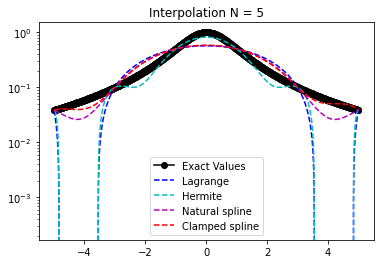

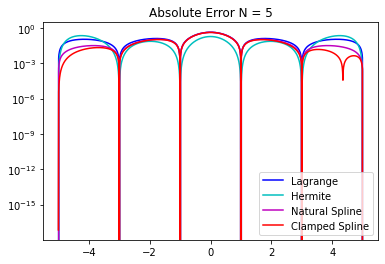

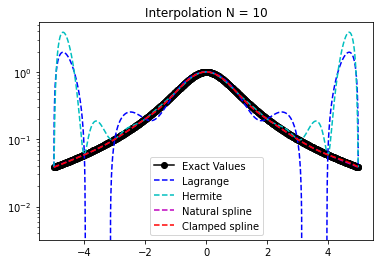

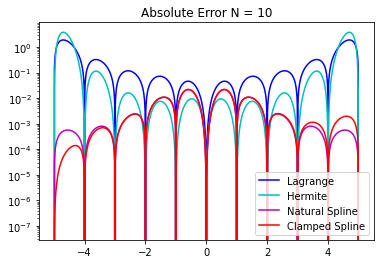

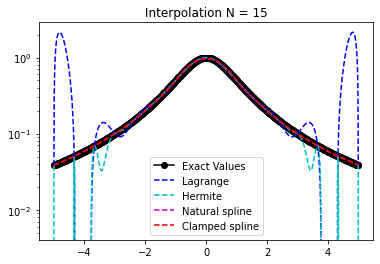

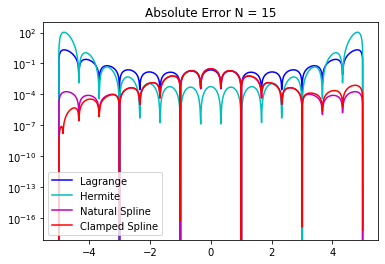

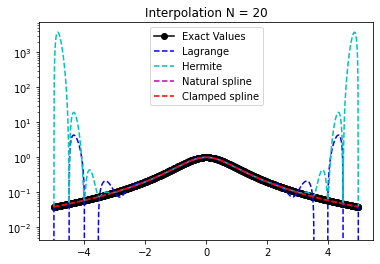

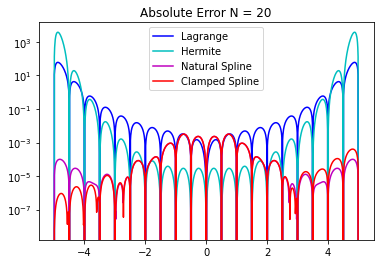

In [50]:
def driver(N):
    
    f = lambda x: 1/(1. + x**2)
    fp = lambda x: -2*x/(1.+x**2)**2
    
    ''' interval'''
    a = -5
    b = 5
    
    ''' create equispaced interpolation nodes'''
    xint = np.linspace(a,b,N+1)
    
    ''' create interpolation data'''
    yint = f(xint)
    ypint = fp(xint)
    
    ''' create points for evaluating the Lagrange interpolating polynomial'''
    Neval = 1000
    xeval = np.linspace(a,b,Neval+1)
    yevalL= np.zeros(Neval+1)
    yevalH = np.zeros(Neval+1)
    yevalNS = np.zeros(Neval+1)
    yevalCS = np.zeros(Neval+1)
    
    ''' evaluate poly '''
    for kk in range(Neval+1):
        yevalL[kk] = eval_lagrange(xeval[kk],xint,yint,N)
        yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N)
    
    #natural cubic spline
    (M,C,D) = create_natural_spline(yint,xint,N)
    yevalNS = eval_cubic_spline(xeval,Neval,xint,N,M,C,D)
    
    #clamped cubic spline
    (M,C,D) = create_clamped_spline(yint,xint,N,fp(a),fp(b))
    yevalCS = eval_cubic_spline(xeval,Neval,xint,N,M,C,D)
    
    ''' create vector with exact values'''
    fex = f(xeval)
    
    plt.figure()
    plt.plot(xeval,fex,'ko-', label='Exact Values')
    plt.plot(xeval,yevalL,'b--', label='Lagrange')
    plt.plot(xeval,yevalH,'c--',label='Hermite')
    plt.plot(xeval,yevalNS,'m--',label='Natural spline')
    plt.plot(xeval,yevalCS,'r--',label='Clamped spline')
    
    plt.semilogy()
    plt.title(f'Interpolation N = {N}')
    plt.legend()
    
    plt.figure()
    errL = abs(yevalL-fex)
    errH = abs(yevalH-fex)
    errNS = abs(yevalNS-fex)
    errCS = abs(yevalCS-fex)
   
    plt.semilogy(xeval,errL,'b',label='Lagrange')
    plt.semilogy(xeval,errH,'c',label='Hermite')
    plt.semilogy(xeval,errNS,'m',label='Natural Spline')
    plt.semilogy(xeval,errCS,'r',label='Clamped Spline')
   
    plt.legend()
    plt.title(f'Absolute Error N = {N}')
    plt.show()
    
driver(5)
driver(10)
driver(15)
driver(20)

Clamped cubic spline interpolation outperforms all other methods overall, however Hermite does better in the middle of the interval. For all values of N, we see that the absolute error for Hermite is the lowest in the middle, but clamped spline does significantly better further towards the end points. For all N except N = 5 there is no visible difference between the plotted true value and the clamped spline interpolation for the whole interval. The natural spline interpolation performs comparably well, however from the error plots it is clear that the clamped spline performs best at the endpoints, and Hermite performs best towards the middle. 

# Problem 2
Chebyshev nodes

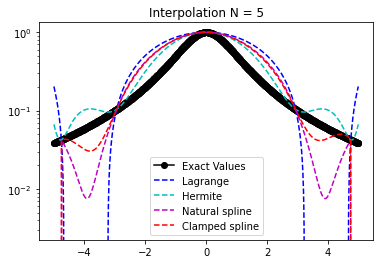

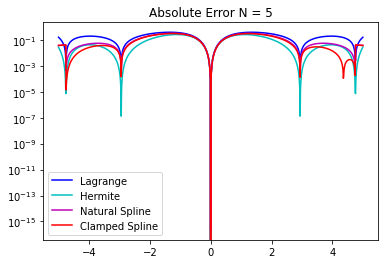

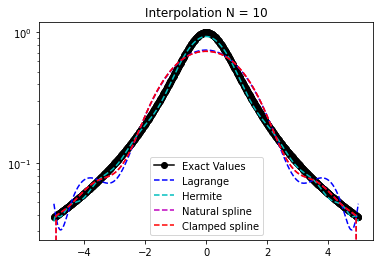

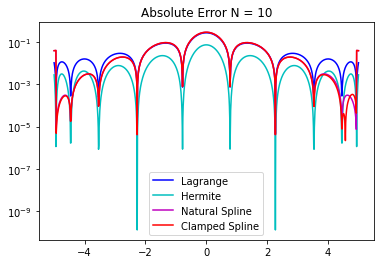

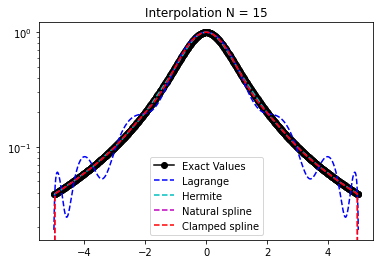

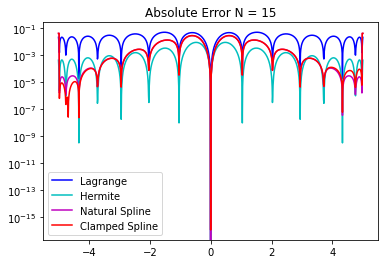

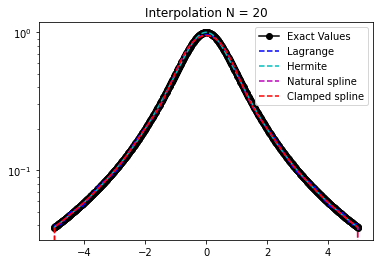

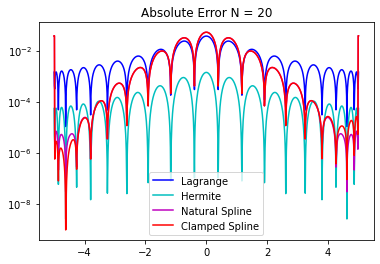

In [86]:
def drivercheb(N):
    
    f = lambda x: 1/(1. + x**2)
    fp = lambda x: -2*x/(1.+x**2)**2
    
    ''' interval'''
    a = -5
    b = 5
    
    ''' create Chebyshev interpolation nodes'''
    xint = np.empty(N)
    
    #multiply by 5 due to range
    xint = 5*np.cos((2*np.arange(1, N+1) - 1)*np.pi/(2*(N)))
    #reverse order to work with splines
    xint = np.flip(xint)

    
    ''' create interpolation data'''
    yint = f(xint)
    ypint = fp(xint)
    
    ''' create points for evaluating the Lagrange interpolating polynomial'''
    Neval = 1000
    xeval = np.linspace(a,b,Neval+1)
    yevalL= np.zeros(Neval+1)
    yevalH = np.zeros(Neval+1)
    yevalNS = np.zeros(Neval+1)
    yevalCS = np.zeros(Neval+1)
    
    ''' evaluate poly '''
    for kk in range(Neval+1):
        yevalL[kk] = eval_lagrange(xeval[kk],xint,yint,N-1)
        yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N-1)
    
    #natural cubic spline
    (M,C,D) = create_natural_spline(yint,xint,N-1)
    yevalNS = eval_cubic_spline(xeval,Neval,xint,N-1,M,C,D)
    
    #clamped cubic spline
    (M,C,D) = create_clamped_spline(yint,xint,N-1,fp(a),fp(b))
    yevalCS = eval_cubic_spline(xeval,Neval,xint,N-1,M,C,D)
    
    ''' create vector with exact values'''
    fex = f(xeval)
    
    plt.figure()
    plt.plot(xeval,fex,'ko-', label='Exact Values')
    plt.plot(xeval,yevalL,'b--', label='Lagrange')
    plt.plot(xeval,yevalH,'c--',label='Hermite')
    plt.plot(xeval,yevalNS,'m--',label='Natural spline')
    plt.plot(xeval,yevalCS,'r--',label='Clamped spline')
    
    plt.semilogy()
    plt.title(f'Interpolation N = {N}')
    plt.legend()
    
    plt.figure()
    errL = abs(yevalL-fex)
    errH = abs(yevalH-fex)
    errNS = abs(yevalNS-fex)
    errCS = abs(yevalCS-fex)
   
    plt.semilogy(xeval,errL,'b',label='Lagrange')
    plt.semilogy(xeval,errH,'c',label='Hermite')
    plt.semilogy(xeval,errNS,'m',label='Natural Spline')
    plt.semilogy(xeval,errCS,'r',label='Clamped Spline')
   
    plt.legend()
    plt.title(f'Absolute Error N = {N}')
    plt.show()
    
drivercheb(5)
drivercheb(10)
drivercheb(15)
drivercheb(20)

All interpolation techniques converge more quickely at the endpoints, as expected with chebyshev nodes. We see this both in the Interpolation plots and in the error plots. Compared to the equispaced nodes, the most significant change at the endpoints is seen for hermite and lagrange, whos error is now much lower at the endpoints.